## Introduction
The following is the code to produce figure 2 to 5 in the paper, with further explanations. For a definition of the **point-adjust** protocol and the way it computes scores, please see the corresponding section in the paper.

In [1]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import binom

import matplotlib
from matplotlib import pyplot as plt

In [2]:
def init_matplotlib(figsize=(16, 6), bgcolor="#FFFFFF"):
    matplotlib.rcParams["figure.figsize"] = figsize
    matplotlib.rcParams["figure.facecolor"] = bgcolor

In [3]:
! mkdir -p  figures

## Hacking point-adjust by randomly tagging points as anomalous
In the following, we consider four datasets that have different sizes but the same contamination rate of $10\%$ (that is, the number of anomalous points to the total number of points). Moreover, anomalous points make up one single segment of contiguous points of size $A$ for each dataset.

For each dataset, we compute the probability of having a perfect **point-adjust** recall by randomly drawing $\alpha$ points from the dataset and tagging them as anomalous, where $\alpha$ is $1\%$ of the total number of points. In the following, we show that large values of $A$ yield larger F1 scores with higher confidence.

Each subplot correspond to a dataset. The x-axis represents given F1 **point-adjust** values (referred to as $\text{F1}_{pa}$) and the y-axis the probability of having an $\text{F1}_{pa}$ value $\le$ a given value on the x-axis.
More precisely, this is the Cumulative Distribution Function (CDF) of $\text{F1}_{pa}$ for each dataset. For convenience, the figure doesn't show the probability for $\text{F1}_{pa}=0$, which is shown in the next figure for the 1st and 4th datasets.

The main takeaway from this figure is that for the same algorithm (''algorithm'' here is a randomly tagging of $1\%$ points as anomalous) large anomalous segments make the score look larger because selecting a point from within the segment does not have the same impact on the different datasets. Typically, we note that while **point-adjust** Recall, $\text{R}_{pa}$ is 1 if at least one randomly selected point lies within the segment, **point-adjust** Precision, $\text{P}_{pa}$ is higher as the difference for larger values of $A$. This is true because if one random point falls within the anomalous segment $\text{P}_{pa} = \frac{A}{A + (\alpha - 1)}$ and we have $\lim_{A\to\infty} \left[\frac{A}{A + (\alpha - 1)}\right] = 1$.

Of course, the more random points falling within the anomalous segment, the better the precision. But here we are interested in calculating the value of **minimum** precision (and the minimum $\text{F1}_{pa}$ score that corresponds to it) reached when just one randomly selected point falls within the anomalous segment and the probability that that happens. This is the probability of having *at least* one random point within the anomalous segment, computed as: $1 - the~probability~of~having~all~random~points~outside~the~segment = 1 - (1 - r)^{\alpha}$. This probability is given by $p(\text{R}_{pa}=1)$ in the title of each subplot.

Note that strictly speaking, the probability of reaching a perfect **point-adjust** recall is $p(\text{R}_{pa}=1) = \sum_{n=1}^{\alpha}{p(\text{TP}=n)}$, where $\text{TP}$ is the **point-wise** True Positive. This is the sum of probabilities of selecting one up to ${\alpha}$ points from the anomalous segment, but in the figure, $p(\text{R}_{pa}=1)$ corresponds to selecting exactly one point from the anomalous segment.

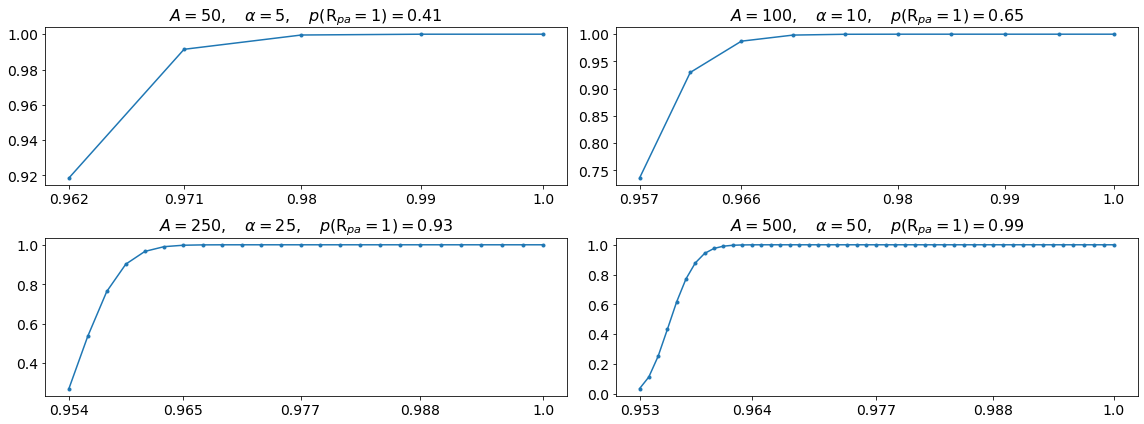

In [4]:
# r: contamination rate
# A: number of anomalous points
# T: total number of points (T = A / r)
# h: percentage of random points tagged as anomalous
# alpha: number of random points tagged as anomalous (alpha = int(T * h))

init_matplotlib(figsize=(16, 6))

r = 0.1
h = 0.01

for i, A in enumerate([50, 100, 250, 500]):

    T = A / 0.1
    alpha = int(T * h)

    # nb hits of anomalous segment
    n_hits = np.arange(0, alpha + 1)
    # point-adjust True Positive
    TP_pa = np.array([0 if n == 0 else A for n in n_hits])

    # probability of perfect point-adjust recall
    proba_perfect_R_pa = 1 - (1 - r) ** alpha

    # point-adjust precision for each number of hits
    # this is an array, so we have one P_pa value for each n_hits
    P_pa = TP_pa / (TP_pa + alpha - n_hits)

    # point-adjust F1 score
    # point-adjust Recall = 1 (with different probabilities!)
    # for one single anomalous segment. This is also an array
    F1_pa = (2 * P_pa * 1) / (P_pa + 1 + 1e-10)

    # we can use the binomial distribution to compute the probability
    # of hitting the anomalous segment a given number of times. We have:
    # n=alpha, k=n_hits and p=r
    
    # We're more interested in the Cumulative Distribution Function of each number
    # of hits, that is, the probability of hitting the anomalous segments at least
    # 'n_hits'. These are also the probabilities of obtaining a point-adjust F1
    # scores below the values computed in F1_pa
    cdf = binom.cdf(k=n_hits, n=alpha, p=r)


    # For convenience, we skip the first value in F1_pa and cdf
    # See next figure with this value included
    F1_pa, cdf = F1_pa[1:], cdf[1:]
    plt.subplot(2, 2, i + 1)
    plt.plot(F1_pa, cdf, ".-")

    plt.title(
        f"$A={A}, \quad \\alpha={alpha}, \quad$"
        + "$p($" + "R$_"
        + "{"
        + "pa"
        + "}=1)="
        + f"{round(proba_perfect_R_pa, 2)}$",
        fontsize=16,
    )
    
    
    indices = [0, len(F1_pa) // 4, len(F1_pa) // 2, int(len(F1_pa) / 4 * 3), len(F1_pa) - 1]
    x_ticks_pos = F1_pa[indices]
    x_ticks_val = np.round(x_ticks_pos, 3)
    plt.xticks(x_ticks_pos, x_ticks_val)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("figures/f1-cdf.pdf", bbox_inches="tight")

## Including the probability of having a null $\text{F1}_{pa}$  score
This figure is comparable to the previous one except that we include the probability of having $\text{F1}_{pa}=0$, and we only consider the two datasets with $A=50$ and $A=500$. This illustrates how big the jump in score can be after hitting the anomalous segment one single time.

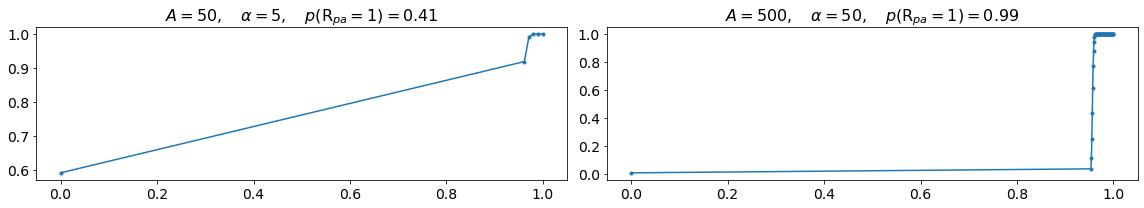

In [5]:
init_matplotlib(figsize=(16, 3))

r = 0.1
h = 0.01

for i, A in enumerate([50, 500]):

    T = A / 0.1
    alpha = int(T * h)

    # nb hits of anomalous segment
    n_hits = np.arange(0, alpha + 1)
    # point-adjust True Positive
    TP_pa = np.array([0 if n == 0 else A for n in n_hits])

    # probability of perfect point-adjust recall
    proba_perfect_R_pa = 1 - (1 - r) ** alpha

    # point-adjust precision for each number of hits
    P_pa = TP_pa / (TP_pa + alpha - n_hits)
    F1_pa = (2 * P_pa * 1) / (P_pa + 1 + 1e-10)

    cdf = binom.cdf(k=n_hits, n=alpha, p=r)

    plt.subplot(1, 2, i + 1)
    plt.plot(F1_pa, cdf, ".-")

    plt.title(
        f"$A={A}, \quad \\alpha={alpha}, \quad$"
        + "$p($" + "R$_"
        + "{"
        + "pa"
        + "}=1)="
        + f"{round(proba_perfect_R_pa, 2)}$",
        fontsize=16,
    )
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout() 
plt.savefig("figures/f1-cdf-full.pdf", bbox_inches="tight")

## Worst $\text{F1}_{pa}$ and $\text{P}_{pa}$ and associated probability
In this figure, we consider a dataset with $A=50$ and the same contamination rate of $0.1$. For different values of $\alpha$ (from $1$ to $30$), we compute the probability of randomly selecting one single point from the anomalous segment (leading to a perfect **point-adjust** recall) and the remaining $\alpha - 1$ points from outside the segment, which corresponds to the worst possible values of F1$_{pa}$ and P$_{pa}$ values when R$_{pa}=1$. We see that certain values of $\alpha$ yield a fairly high F1$_{pa}$ score for a random guess algorithm, with high probability.

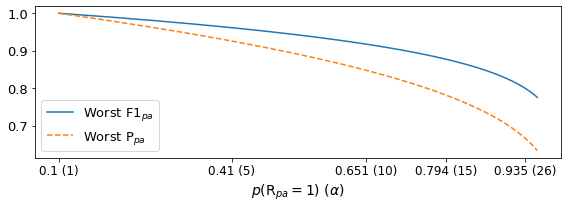

In [6]:
init_matplotlib(figsize=(8, 3), bgcolor="#FFFFFF")
A = 50
alpha = np.arange(1, 31)
proba_perfect_R_pa = 1 - (1 - r) ** alpha

P = A / (A + alpha - 1)
F1 = (2 * P * 1) / (P + 1)

label = "$p($" + "R$_" + "{" + "pa" + "}=1)~$" + "($\\alpha$)"

plt.xlabel(label, fontsize=14)
# plt.ylabel("Precision")

x_ticks_pos = proba_perfect_R_pa
x_ticks_val = np.array([f"{round(p, 3)} ({a})" for p, a in zip(proba_perfect_R_pa, alpha)])
indices = [0, 4, 9, 14, -5]
plt.xticks(x_ticks_pos[indices], x_ticks_val[indices], fontsize=14)

plt.plot(proba_perfect_R_pa, F1, label="Worst F1$_{pa}$")
plt.plot(proba_perfect_R_pa, P, "--", label="Worst P$_{pa}$")
plt.legend(fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tight_layout() 
plt.savefig("figures/f1-pa-A50-worst-case.pdf", bbox_inches="tight")


## Point-wise F1 score of a given detector with datasets of different contamination rates
In this figure, we consider many anomaly detectors with the same probability ($0.99$) of classifying a point as anomalous when the point is actually anomalous, but with different False Alarm Rates (FAR). For each detector (one tick on the x-axis), we compute the expected **point-wise** F1 score with three different datasets. The datasets have different contamination rates: $0.33$, $0.091$ and $0.01$.

We see that for almost all detectors, the F1 score is better for datasets with higher contamination rates. Particularly, we observe that the difference between the best and the worst detectors is the smallest for the dataset with the highest contamination rate.

The goal of this part is to show that, for the same detector, the **point-wise** performance may vary greatly as a function of the contamination rate of the dataset. It is reminiscent of the main [weakness](https://datascience.stackexchange.com/questions/110124/what-are-the-disadvantages-of-accuracy) of the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) for which the F1 score is the recommended alternative in the first place. Actually, in extreme cases where the contamination rate is very high, the F1 score becomes very high across all detectors (try adding a big number such as $20000$ to the list in line `zip([5000, 1000, 100] ...`).

The FAR and Recall of a given detector, however, are constant across datasets and have a much more intuitive interpretation than the F1 score. This makes them very interesting for evaluating anomaly detection algorithms.

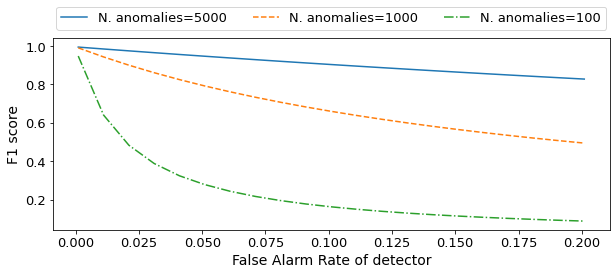

In [7]:
# n_normal: number of normal points in data
# n_anomalous: number of anomalous points in data
# proba_ano_ano: probability that the detector correctly detects an anomalous point as such
# FAR: False Alarm Rate of detector

init_matplotlib((9, 4), bgcolor="#FFFFFF")

n_normal = 10000
proba_ano_ano = 0.99
FAR = np.arange(0.001, 0.202, 0.01)

fig, ax = plt.subplots()


for n_anomalous, fmt in zip([5000, 1000, 100], ["-", "--", "-."]):
    y = []
    for far in FAR:
        TP = proba_ano_ano * n_anomalous
        FP = far * n_normal
        FN = n_anomalous - TP
        P = (TP) / (TP + FP)
        R = TP / (TP + FN)
        assert R == proba_ano_ano

        F1 = (2 * P * R) / (P + R)
        y.append(F1)

    y = np.array(y)
    ax.plot(FAR, y, fmt, label=f"N. anomalies={n_anomalous}")

plt.xlabel("False Alarm Rate of detector", fontsize=14)
plt.ylabel("F1 score", fontsize=14)

_ = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    fancybox=True,
    shadow=False,
    ncol=4,
    fontsize=13,
)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout() 
plt.savefig("figures/detector-var-far.pdf", bbox_inches="tight")